# CosmoDC2 v1.0: galaxy position(Spark)
<br> Kernel: **desc-pyspark**
<br>Owner: **S Plaszczynski** (https://github.com/LSSTDESC/DC2-production/issues/299)
<br>Last Verified to Run: **2018-12-03**
    
The goal of this notebook is to study the galaxy positions of the full CosmoDC2 v1 catalog.

It also a good way to learn Spark.
Note however that notebooks are really not well suited to analyzing the full-DC2 dataset(because of jupyter-dev limitations): **you will get much better
results running on interactive queues** see : https://github.com/LSSTDESC/desc-spark

# reading parquet data

In [1]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()
print("spark session started")

#usefull class to benchmark
from time import time
class Timer:
    """
    a simple class for printing time (s) since last call
    """
    def __init__(self):
        self.t0=time()
    
    def start(self):
        self.t0=time()
        
    def stop(self):
        t1=time()
        print("{:2.1f}s".format(t1-self.t0))

timer=Timer()

spark session started


I created some excerpt of cosmo_DC2_v10 (full) data within a parquet file

In [2]:
timer.start()
df_all=spark.read.parquet("/global/cscratch1/sd/plaszczy/CosmoDC2/xyz_v1.0.parquet")
df_all.printSchema()
timer.stop()

root
 |-- position_y: float (nullable = true)
 |-- dec: float (nullable = true)
 |-- ra: float (nullable = true)
 |-- redshift_true: float (nullable = true)
 |-- halo_id: long (nullable = true)
 |-- position_x: float (nullable = true)
 |-- position_z: float (nullable = true)
 |-- is_central: boolean (nullable = true)
 |-- redshift: float (nullable = true)

6.4s


In [ ]:
timer.start()
df=df_all.select('ra','dec','redshift','redshift_true').cache()
N=df.count()
print(N/1e9)
timer.stop()

some usfeull tools

In [6]:
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F

def minmax(df,col):
    return df.select(F.min(col),F.max(col)).first()

def df_histo(df,col,Nbins,bounds=None):
    if (bounds==None) :
        m=minmax(df,col)
        zmin=minmax[0]
        zmax=minmax[1]
    else:
        zmin=bounds[0]
        zmax=bounds[1]
        df=df.filter(df[col].between(zmin,zmax))
    
    dz=(zmax-zmin)/Nbins
    zbin=df.select(df[col],((df[col]-zmin-dz/2)/dz).cast(IntegerType()).alias('bin'))
    h=zbin.groupBy("bin").count().orderBy(F.asc("bin"))
    return h.select("bin",(zmin+dz/2+h['bin']*dz).alias('loc'),"count").drop("bin")

# redshift distribution

In [16]:
timer.start()
m=minmax(df,'redshift')
print(r"$z \in [{},{}]$".format(m[0],m[1]))
timer.stop()

$z \in [0.00038306356873363256,3.1929798126220703]$
18.3s


In [17]:
timer.start()
h_z=df_histo(df,'redshift',100,bounds=(0,3)).toPandas()
h_z0=df_histo(df,'redshift_true',100,bounds=(0,3)).toPandas()
timer.stop()

132.1s


Text(0,0.5,'dN/dz')

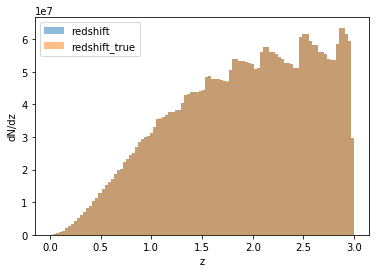

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

dz=3./100

plt.bar(h_z['loc'].values,h_z['count'].values,dz,label='redshift',alpha=0.5)
plt.bar(h_z0['loc'].values,h_z0['count'].values,dz,label='redshift_true',alpha=0.5)
plt.legend()
plt.xlabel("z")
plt.ylabel("dN/dz")

# footprint

In [ ]:
Build a high resolution healpix map and project all galaxies inside

In [ ]:
timer.start()
import pandas as pd
import numpy as np
import healpy as hp
from pyspark.sql.functions import pandas_udf, PandasUDFType

nside=2048
#create the ang2pix user-defined-function. 
#we use pandas_udf because they are more efficient
@pandas_udf('int', PandasUDFType.SCALAR)
def Ang2Pix(ra,dec):
    return pd.Series(hp.ang2pix(nside,np.radians(90-dec),np.radians(ra)))

#add a column of healpix indices
df=df.withColumn("ipix",Ang2Pix("ra","dec"))
#groupby indices and count the number of elements in each group
df_map=df.groupBy("ipix").count()
#statistics per pixel
df_map.describe(['count']).show() 

#back to python world
map_p=df_map.toPandas()

#now data is reduced create the healpy map
count_map = np.zeros(hp.nside2npix(nside))
count_map[map_p['ipix'].values]=map_p['count'].values
#count_map[counts_map==0]=hp.UNSEEN
timer.stop()

(array([1.07300e+03, 3.28000e+02, 1.66000e+02, 1.30000e+02, 7.50000e+01,
        9.60000e+01, 1.54000e+02, 1.42000e+02, 1.25000e+02, 1.34000e+02,
        1.24000e+02, 1.34000e+02, 1.06000e+02, 7.70000e+01, 8.50000e+01,
        1.11000e+02, 1.24000e+02, 1.22000e+02, 1.02000e+02, 8.30000e+01,
        8.50000e+01, 7.30000e+01, 1.04000e+02, 1.04000e+02, 1.03000e+02,
        9.00000e+01, 8.80000e+01, 9.50000e+01, 1.16000e+02, 1.08000e+02,
        1.16000e+02, 1.49000e+02, 5.23000e+02, 4.98200e+03, 3.53130e+04,
        1.32534e+05, 2.51273e+05, 2.56158e+05, 1.53594e+05, 5.84970e+04,
        1.67540e+04, 4.15400e+03, 9.72000e+02, 2.49000e+02, 8.10000e+01,
        2.50000e+01, 1.20000e+01, 3.00000e+00, 0.00000e+00, 3.00000e+00]),
 array([1.00000e+00, 1.14340e+02, 2.27680e+02, 3.41020e+02, 4.54360e+02,
        5.67700e+02, 6.81040e+02, 7.94380e+02, 9.07720e+02, 1.02106e+03,
        1.13440e+03, 1.24774e+03, 1.36108e+03, 1.47442e+03, 1.58776e+03,
        1.70110e+03, 1.81444e+03, 1.92778e+03, 2.

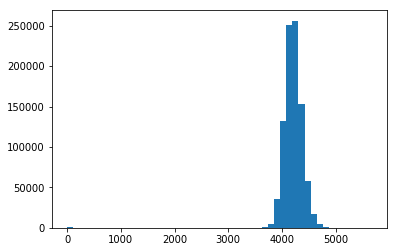

In [31]:
plt.hist(count_map[count_map>0],bins=50)

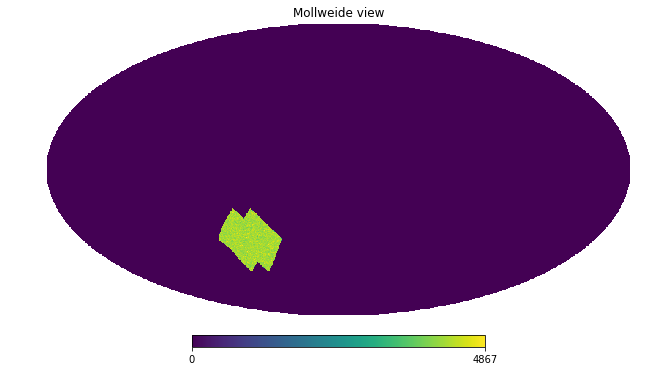

In [32]:
hp.mollview(count_map)

where is the center?

In [35]:
df.describe(['ra','dec']).show()

+-------+-----------------+------------------+
|summary|               ra|               dec|
+-------+-----------------+------------------+
|  count|       3862614101|        3862614101|
|   mean|62.32386776858061|-36.00731936059433|
| stddev|9.952789220855259| 7.756809170315573|
|    min|        39.382427|        -54.337822|
|    max|         84.38016|        -19.462912|
+-------+-----------------+------------------+



Let us zoom now

<Figure size 432x288 with 0 Axes>

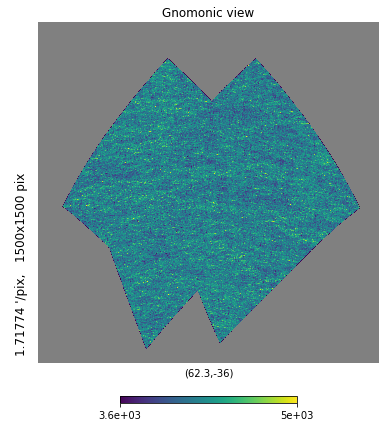

In [53]:
count_map[count_map==0]=hp.UNSEEN
hp.gnomview(count_map,rot=[62.3,-36.],reso=hp.nside2resol(nside,arcmin=True),xsize=1500,min=3600,max=5000)

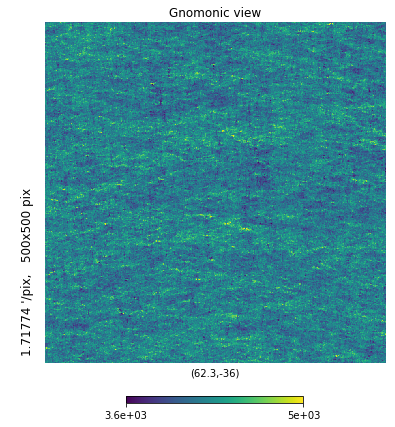

In [54]:
hp.gnomview(count_map,rot=[62.3,-36.],reso=hp.nside2resol(nside,arcmin=True),xsize=500,min=3600,max=5000)

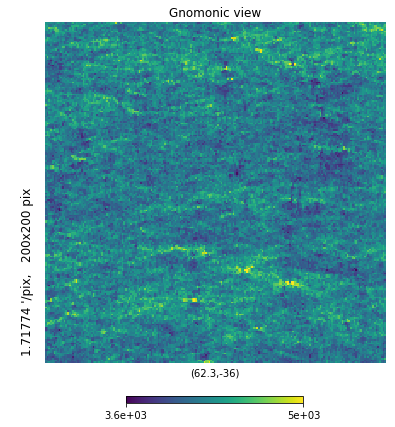

In [55]:
hp.gnomview(count_map,rot=[62.3,-36.],reso=hp.nside2resol(nside,arcmin=True),xsize=200,min=3600,max=5000)